# Multi-Horizon LSTM Model Training
Build and train LSTM models for Gulf hypoxia prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

from codecarbon import EmissionsTracker

# Set random seeds for reproducibility
np.random.seed(5550)
tf.random.set_seed(5550)

In [2]:
DATA_DIR = Path('data/modeling')
OUTPUT_DIR = Path('models/lstm')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 8
EPOCHS = 200
PATIENCE = 30  # Early stopping patience

In [3]:
X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

n_samples_train, n_timesteps, n_features = X_train.shape
n_targets = y_train.shape[1]

print(f"  Training samples: {n_samples_train}")
print(f"  Timesteps (sequence length): {n_timesteps}")
print(f"  Features per timestep: {n_features}")
print(f"  Target zones: {n_targets}")

  X_train: (51, 6, 30)
  y_train: (51, 3)
  X_val: (9, 6, 30)
  y_val: (9, 3)
  X_test: (6, 6, 30)
  y_test: (6, 3)
  Training samples: 51
  Timesteps (sequence length): 6
  Features per timestep: 30
  Target zones: 3


In [4]:
def build_lstm_model_v1(input_shape, n_targets, name="lstm_v1"):
    """
    Basic LSTM model with 2 LSTM layers
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer (3 zones, no activation for regression)
    model.add(layers.Dense(n_targets))
    
    return model

def build_lstm_model_v2(input_shape, n_targets, name="lstm_v2"):
    """
    Deeper LSTM model with 3 LSTM layers
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # LSTM layers
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Dense(16, activation='relu'))
    
    # Output layer
    model.add(layers.Dense(n_targets))
    
    return model

def build_lstm_model_v3(input_shape, n_targets, name="lstm_v3"):
    """
    Bidirectional LSTM model
    Uses Masking to handle zero-padded sequences
    """
    
    model = models.Sequential(name=name)
    
    # Masking layer to ignore zero-padded timesteps
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))
    
    # Bidirectional LSTM layers
    model.add(layers.Bidirectional(
        layers.LSTM(64, return_sequences=True)
    ))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Bidirectional(
        layers.LSTM(32, return_sequences=False)
    ))
    model.add(layers.Dropout(0.2))
    
    # Dense layers
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output layer
    model.add(layers.Dense(n_targets))
    
    return model

# Build all model variants
input_shape = (n_timesteps, n_features)

models_to_train = {
    'lstm_v1': build_lstm_model_v1(input_shape, n_targets),
    'lstm_v2': build_lstm_model_v2(input_shape, n_targets),
    'lstm_v3_bidirectional': build_lstm_model_v3(input_shape, n_targets),
}

print("\nModel architectures:")
for name, model in models_to_train.items():
    print(f"\n{name.upper()}:")
    model.summary()
    print(f"  Total parameters: {model.count_params():,}")


Model architectures:

LSTM_V1:


Model: "lstm_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,315 (145.76 KB)

 Trainable params: 37,315 (145.76 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 37,315

LSTM_V2:


Model: "lstm_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 6, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,867 (565.89 KB)

 Trainable params: 144,867 (565.89 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 144,867

LSTM_V3_BIDIRECTIONAL:


Model: "lstm_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6, 128)         │        48,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,947 (355.26 KB)

 Trainable params: 90,947 (355.26 KB)

 Non-trainable params: 0 (0.00 B)

  Total parameters: 90,947


In [5]:
tracker1 = EmissionsTracker(
    project_name="gulf_hypoxia",
    output_dir="models/lstm"
)

tracker1.start()

[codecarbon WARNING @ 20:47:36] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 20:47:36] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 20:47:36] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:36] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:36] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 20:47:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 20:47:36] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon WARNING @ 20:47:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:47:36] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:36] No GPU found.
[codecarbon INFO @ 20:47:36] The below tracking methods have been set up:
    

In [6]:
training_histories = {}

for model_name, model in models_to_train.items():
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name.upper()}")
    print(f"{'='*80}")
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    training_histories[model_name] = history.history
    
    # Save model
    model.save(OUTPUT_DIR / f'{model_name}.keras')
    print(f"\n✓ Saved model: {model_name}.keras")

# Save training histories
with open(OUTPUT_DIR / 'training_histories.pkl', 'wb') as f:
    pickle.dump(training_histories, f)


TRAINING: LSTM_V1
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 347.7434 - mae: 11.0472 - val_loss: 81.7200 - val_mae: 5.7036 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 345.0521 - mae: 10.9991 - val_loss: 80.9588 - val_mae: 5.6959 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 341.2703 - mae: 10.9376 - val_loss: 79.6892 - val_mae: 5.6846 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 336.8030 - mae: 10.8683 - val_loss: 77.5027 - val_mae: 5.6604 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 328.8411 - mae: 10.7184 - val_loss: 74.5871 - val_mae: 5.6419 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 319.8659 - mae: 10.5754 - val_loss: 71.0118 - val_mae: 5.6368 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 307.3063 - mae: 10.3864 - val_loss: 67.3686 - val_mae: 5.6830

[codecarbon INFO @ 20:47:55] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:47:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:47:55] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 20:47:55] 0.000202 kWh of electricity and 0.000000 L of water were used since the beginning.


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 345.3783 - mae: 10.9817 - val_loss: 78.6351 - val_mae: 5.6823 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 333.2673 - mae: 10.7252 - val_loss: 73.5813 - val_mae: 5.6462 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 319.2234 - mae: 10.4385 - val_loss: 66.6100 - val_mae: 5.6287 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 290.8873 - mae: 9.9733 - val_loss: 58.6134 - val_mae: 5.6521 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 255.8238 - mae: 9.4837 - val_loss: 54.2309 - val_mae: 5.7272 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 224.3803 - mae: 8.9909 - val_loss: 55.4941 - val_mae: 5.8444 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 195.7990 - mae: 8.6047 - val_loss: 61.7542 - val_mae: 5.9743 - learning_rate: 0.0010
Epoch 8/

In [7]:
zone_names = ['Zone 1 (Louisiana)', 'Zone 2 (Texas)', 'Zone 3 (Mexico)']

def evaluate_model(model, X, y, dataset_name):
    """Evaluate model and return metrics"""
    
    y_pred = model.predict(X, verbose=0)
    
    # Overall metrics
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Per-zone metrics
    zone_metrics = []
    for i, zone_name in enumerate(zone_names):
        zone_mse = mean_squared_error(y[:, i], y_pred[:, i])
        zone_mae = mean_absolute_error(y[:, i], y_pred[:, i])
        zone_r2 = r2_score(y[:, i], y_pred[:, i])
        
        zone_metrics.append({
            'zone': zone_name,
            'mse': zone_mse,
            'mae': zone_mae,
            'r2': zone_r2
        })
    
    return {
        'dataset': dataset_name,
        'overall_mse': mse,
        'overall_mae': mae,
        'overall_r2': r2,
        'zone_metrics': zone_metrics,
        'predictions': y_pred
    }

# Evaluate all models
results = {}

for model_name, model in models_to_train.items():
    print(f"\n{model_name.upper()}:")
    print(f"{'-'*40}")
    
    model_results = {
        'train': evaluate_model(model, X_train, y_train, 'train'),
        'val': evaluate_model(model, X_val, y_val, 'validation'),
        'test': evaluate_model(model, X_test, y_test, 'test')
    }
    
    results[model_name] = model_results
    
    # Print results
    for dataset in ['train', 'val', 'test']:
        res = model_results[dataset]
        print(f"\n  {dataset.upper()}:")
        print(f"    Overall MAE: {res['overall_mae']:.2f}%")
        print(f"    Overall R²: {res['overall_r2']:.3f}")
        print(f"    Per-zone MAE:")
        for zone_metric in res['zone_metrics']:
            print(f"      {zone_metric['zone']}: {zone_metric['mae']:.2f}%")

# Save results
with open(OUTPUT_DIR / 'evaluation_results.pkl', 'wb') as f:
    pickle.dump(results, f)


LSTM_V1:
----------------------------------------

  TRAIN:
    Overall MAE: 8.68%
    Overall R²: -1.065
    Per-zone MAE:
      Zone 1 (Louisiana): 5.61%
      Zone 2 (Texas): 18.22%
      Zone 3 (Mexico): 2.21%

  VAL:
    Overall MAE: 6.06%
    Overall R²: -0.254
    Per-zone MAE:
      Zone 1 (Louisiana): 7.85%
      Zone 2 (Texas): 7.15%
      Zone 3 (Mexico): 3.20%

  TEST:
    Overall MAE: 4.23%
    Overall R²: -1.186
    Per-zone MAE:
      Zone 1 (Louisiana): 2.75%
      Zone 2 (Texas): 7.69%
      Zone 3 (Mexico): 2.27%

LSTM_V2:
----------------------------------------

  TRAIN:
    Overall MAE: 9.02%
    Overall R²: -0.818
    Per-zone MAE:
      Zone 1 (Louisiana): 6.24%
      Zone 2 (Texas): 19.76%
      Zone 3 (Mexico): 1.04%

  VAL:
    Overall MAE: 5.99%
    Overall R²: -0.630
    Per-zone MAE:
      Zone 1 (Louisiana): 8.57%
      Zone 2 (Texas): 6.40%
      Zone 3 (Mexico): 2.99%

  TEST:
    Overall MAE: 2.76%
    Overall R²: -0.831
    Per-zone MAE:
      Zone 1 

In [8]:
comparison_df = []
for model_name, model_results in results.items():
    comparison_df.append({
        'model': model_name,
        'train_mae': model_results['train']['overall_mae'],
        'val_mae': model_results['val']['overall_mae'],
        'test_mae': model_results['test']['overall_mae'],
        'train_r2': model_results['train']['overall_r2'],
        'val_r2': model_results['val']['overall_r2'],
        'test_r2': model_results['test']['overall_r2']
    })

comparison_df = pd.DataFrame(comparison_df)
comparison_df = comparison_df.sort_values('val_mae')

print("\nModel Comparison (sorted by validation MAE):")
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['model']
print(f"\nBest model: {best_model_name}")
print(f"  Validation MAE: {comparison_df.iloc[0]['val_mae']:.2f}%")
print(f"  Test MAE: {comparison_df.iloc[0]['test_mae']:.2f}%")


Model Comparison (sorted by validation MAE):
                model  train_mae  val_mae  test_mae  train_r2    val_r2   test_r2
lstm_v3_bidirectional   8.258079 5.727155  3.432066 -0.434564 -0.383248 -1.562803
              lstm_v2   9.015132 5.988515  2.756404 -0.817752 -0.629752 -0.830602
              lstm_v1   8.679296 6.064858  4.233763 -1.064813 -0.253770 -1.186212

Best model: lstm_v3_bidirectional
  Validation MAE: 5.73%
  Test MAE: 3.43%


KeyError: 'test_horizons'

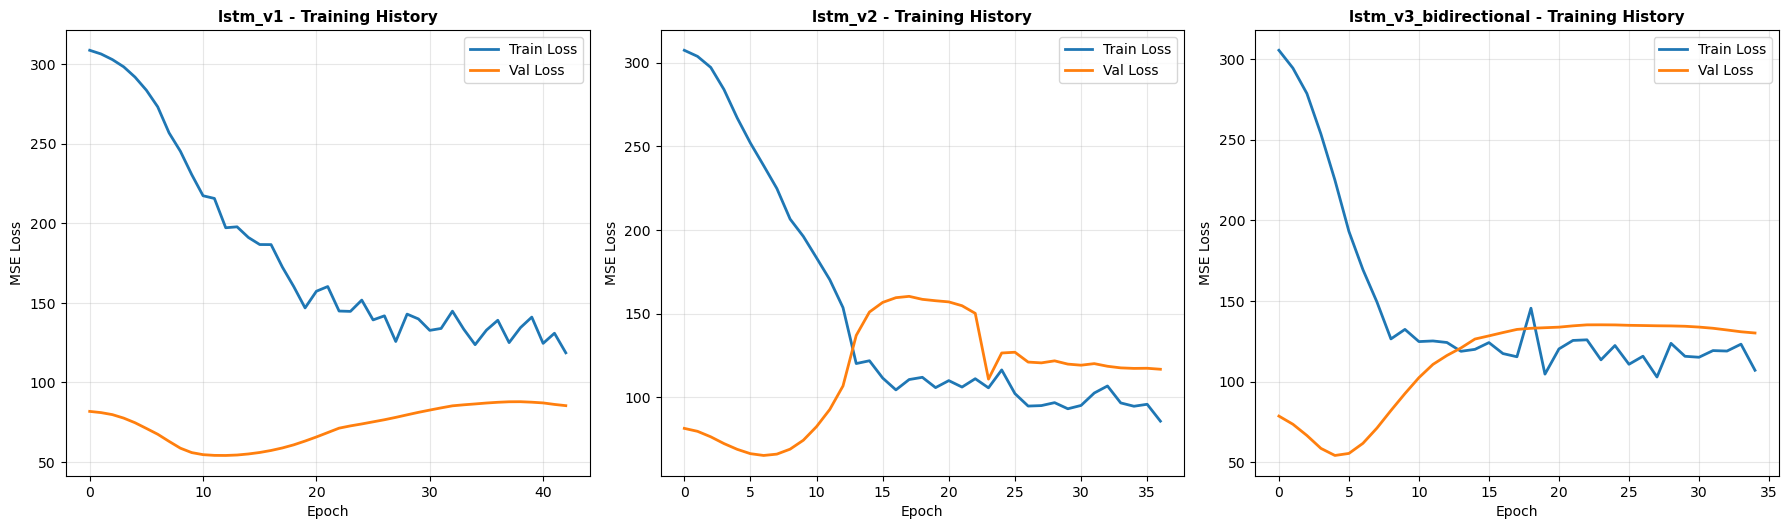

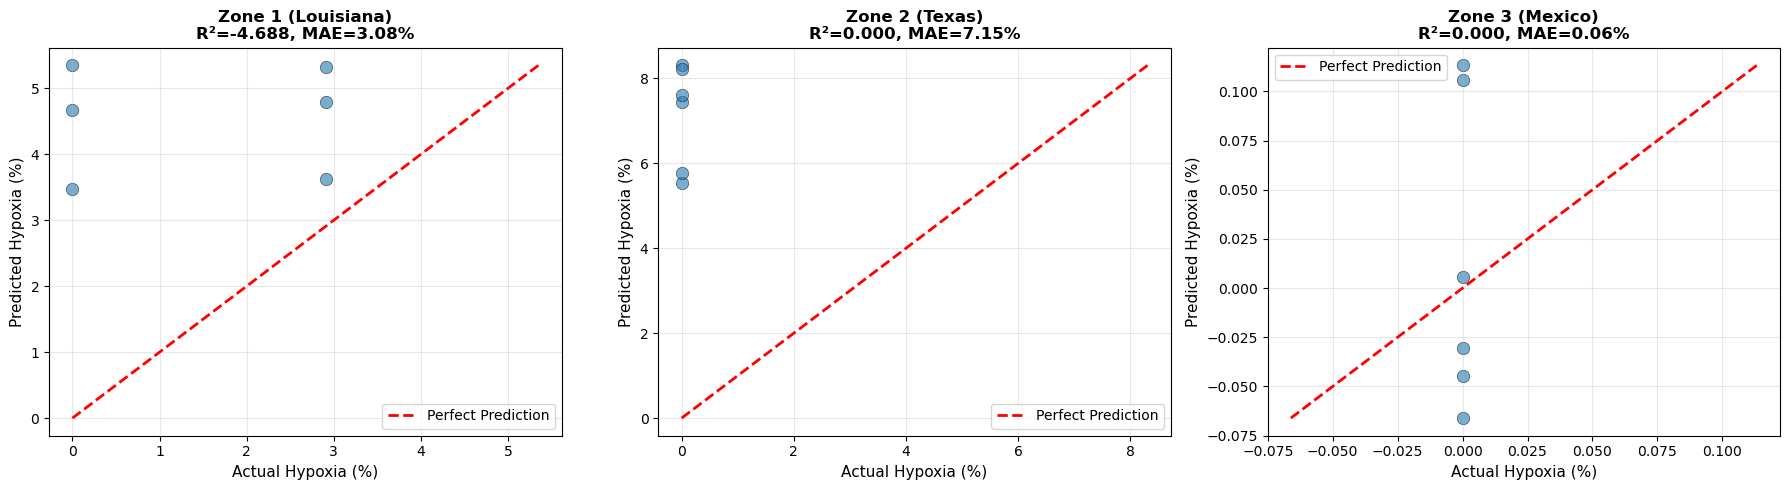

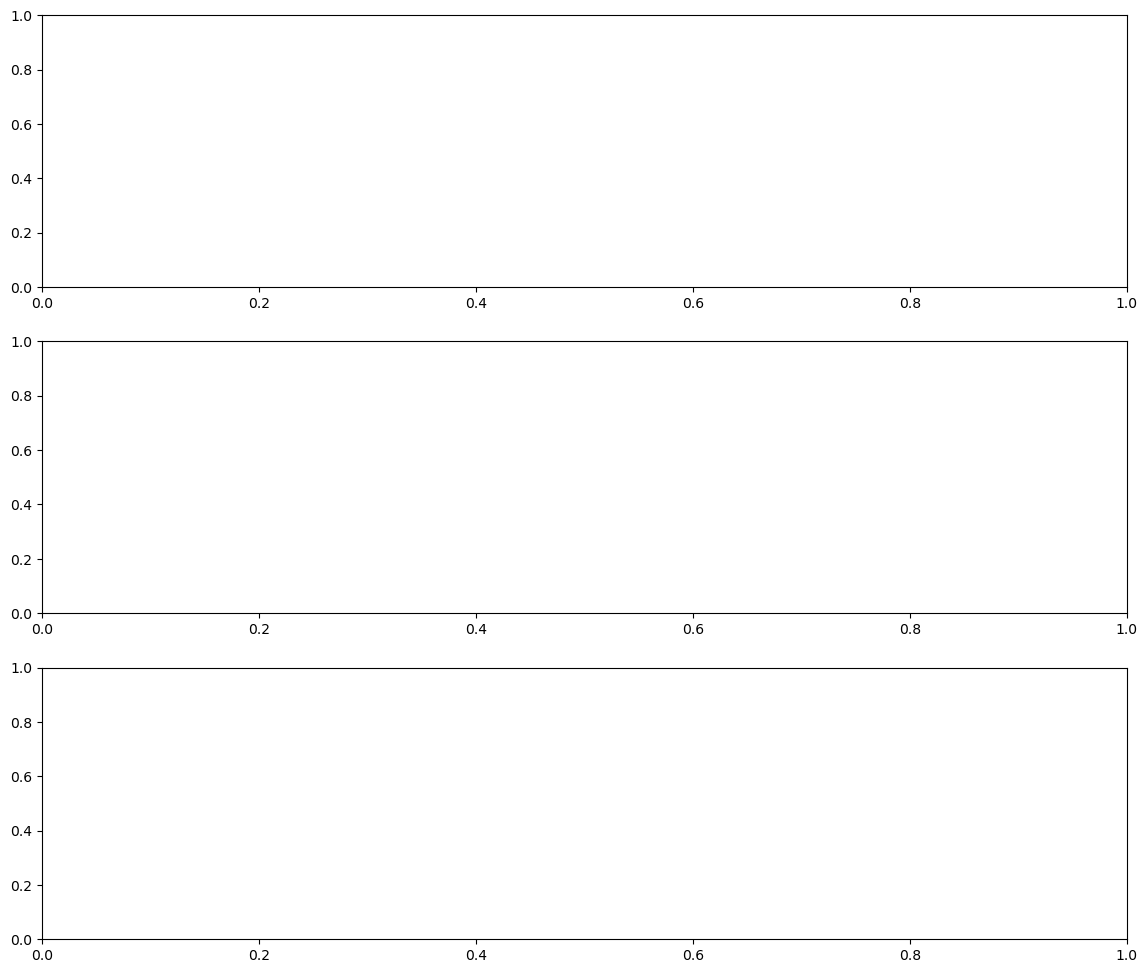

[codecarbon INFO @ 20:48:10] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:10] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 20:48:10] 0.000404 kWh of electricity and 0.000000 L of water were used since the beginning.


In [ ]:

# Figure 1: Training histories
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (model_name, history) in enumerate(training_histories.items()):
    ax = axes[i]
    
    # Plot loss
    ax.plot(history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('MSE Loss', fontsize=10)
    ax.set_title(f'{model_name} - Training History', fontweight='bold', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for i in range(len(training_histories), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

# Figure 2: Predictions vs Actual (Test Set) - Best Model
best_model = models_to_train[best_model_name]
best_results = results[best_model_name]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, zone_name in enumerate(zone_names):
    ax = axes[i]
    
    y_true = y_test[:, i]
    y_pred = best_results['test']['predictions'][:, i]
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    ax.set_xlabel('Actual Hypoxia (%)', fontsize=11)
    ax.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
    ax.set_title(f'{zone_name}\nR²={r2:.3f}, MAE={mae:.2f}%', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

# Figure 3: Predictions over time (Test Set)
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

test_years = metadata['test_years']
test_horizons = metadata['test_horizons']

for i, zone_name in enumerate(zone_names):
    ax = axes[i]
    
    y_true = y_test[:, i]
    y_pred = best_results['test']['predictions'][:, i]
    
    x = np.arange(len(y_true))
    
    # Plot actual and predicted
    ax.plot(x, y_true, 'o-', label='Actual', linewidth=2, markersize=8)
    ax.plot(x, y_pred, 's--', label='Predicted', linewidth=2, markersize=8)
    
    # Add year labels
    ax.set_xticks(x)
    labels = [f"{year}\n{horizon.replace('_', ' ')}" for year, horizon in zip(test_years, test_horizons)]
    ax.set_xticklabels(labels, fontsize=9, rotation=0)
    
    ax.set_ylabel('Hypoxia (%)', fontsize=11)
    ax.set_title(f'{zone_name} - Test Set Predictions', fontweight='bold', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

In [10]:
emissions_lstm = tracker1.stop()
print(f"Carbon footprint: {emissions_lstm * 1000:.3f}g CO₂eq")

[codecarbon INFO @ 20:48:13] Energy consumed for RAM : 0.000056 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:13] Delta energy consumed for CPU with constant : 0.000041 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:13] Energy consumed for All CPU : 0.000395 kWh
[codecarbon INFO @ 20:48:13] 0.000451 kWh of electricity and 0.000000 L of water were used since the beginning.


Carbon footprint: 0.166g CO₂eq


In [14]:
OUTPUT_DIR = Path('models/random_forest')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

tracker2 = EmissionsTracker(
    project_name="gulf_hypoxia",
    output_dir="models/random_forest"
)

tracker2.start()

[codecarbon WARNING @ 20:48:47] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 20:48:47] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 20:48:47] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:47] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:47] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 20:48:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 20:48:47] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon WARNING @ 20:48:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:48:47] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:47] No GPU found.
[codecarbon INFO @ 20:48:47] The below tracking methods have been set up:
    


Total samples: 60
Features: 180

Fold 1/5:
  Val MAE: 6.10%
  Val R²: -0.866

Fold 2/5:
  Val MAE: 6.04%
  Val R²: 0.557

Fold 3/5:
  Val MAE: 5.93%
  Val R²: 0.501

Fold 4/5:
  Val MAE: 5.05%
  Val R²: 0.548

Fold 5/5:
  Val MAE: 5.84%
  Val R²: 0.543
CROSS-VALIDATION SUMMARY:
  Average MAE: 5.79% ± 0.43%
  Average R²: 0.256 ± 0.628

Train/Val combined performance:
  MAE: 3.75%
  R²: 0.800

Test set (2023-2024) performance:
  MAE: 6.22%
  R²: -11.104

  Zone 1 (Louisiana):
    Actual range: 0.0%-2.9%
    Predicted range: 4.4%-9.9%
    MAE: 5.76%

  Zone 2 (Texas):
    Actual range: 0.0%-0.0%
    Predicted range: 4.8%-8.9%
    MAE: 6.68%

 Saved: rf_final_regularized.pkl


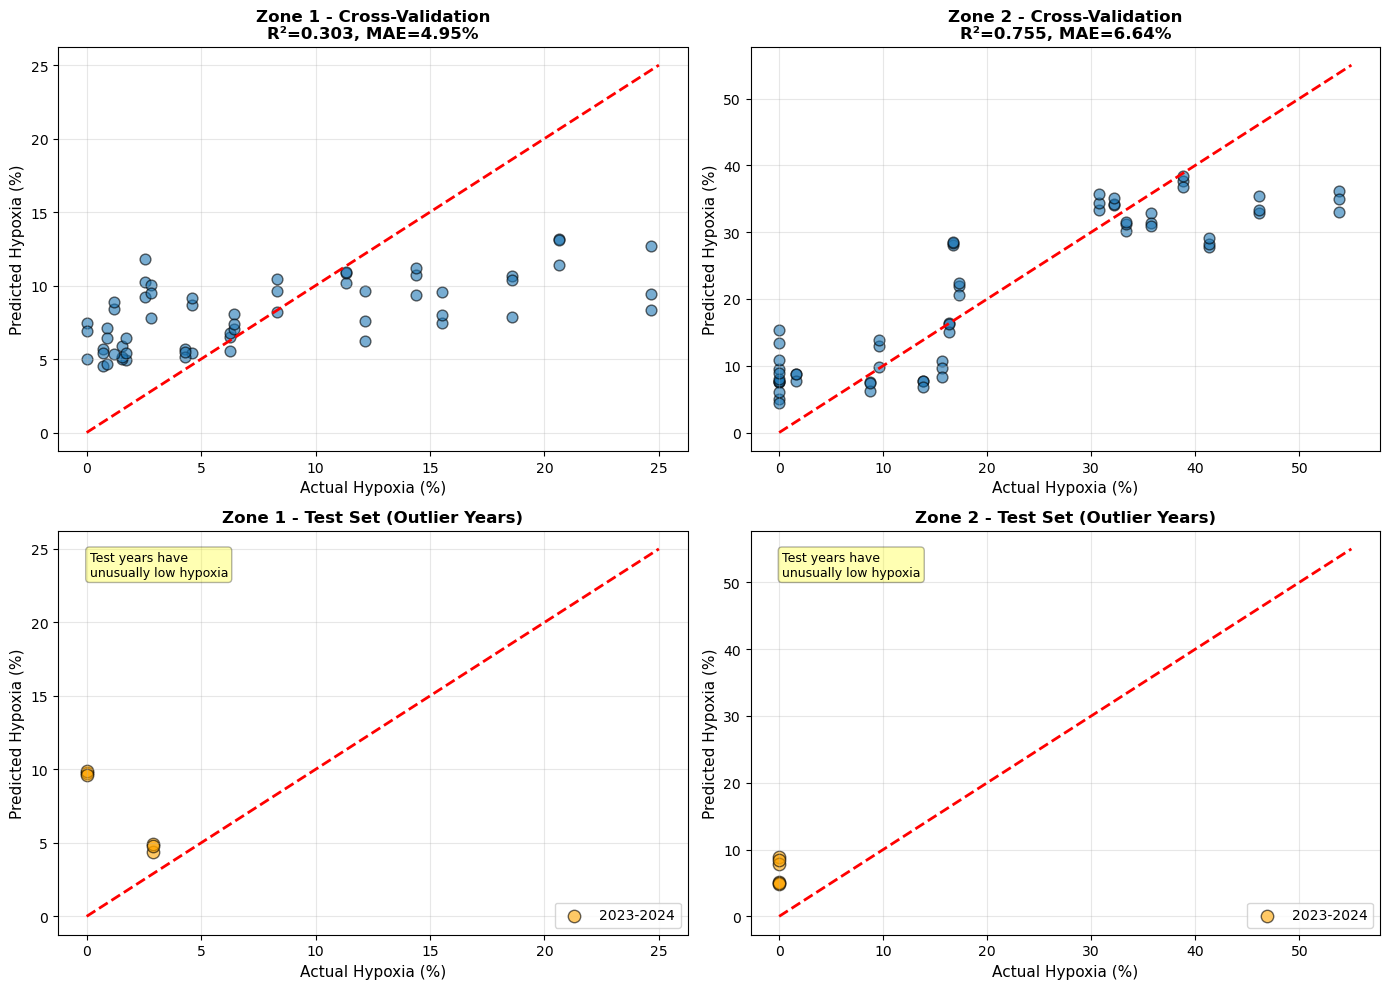

In [15]:
"""
Cross-Validated Random Forest with Realistic Evaluation
Use k-fold CV instead of temporal split since 2023-2024 are outliers
"""

DATA_DIR = Path('data/modeling')
OUTPUT_DIR = Path('models/random_forest')

X_train = np.load(DATA_DIR / 'X_train.npy')
y_train = np.load(DATA_DIR / 'y_train.npy')
X_val = np.load(DATA_DIR / 'X_val.npy')
y_val = np.load(DATA_DIR / 'y_val.npy')
X_test = np.load(DATA_DIR / 'X_test.npy')
y_test = np.load(DATA_DIR / 'y_test.npy')

with open(DATA_DIR / 'metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Flatten for tree models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Drop Zone 3, combine train+val
y_2zone_train = y_train[:, :2]
y_2zone_val = y_val[:, :2]
y_2zone_test = y_test[:, :2]

X_all = np.vstack([X_train_flat, X_val_flat])
y_all = np.vstack([y_2zone_train, y_2zone_val])

print(f"\nTotal samples: {len(X_all)}")
print(f"Features: {X_all.shape[1]}")


kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
fold_predictions = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all), 1):
    print(f"\nFold {fold}/5:")
    
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_val_fold = X_all[val_idx]
    y_val_fold = y_all[val_idx]
    
    # Train with MORE regularization to prevent overfitting
    rf = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=100,  # Reduced from 200
            max_depth=5,       # Reduced from 10
            min_samples_split=10,  # Increased from 5
            min_samples_leaf=5,    # Increased from 2
            max_features='sqrt',   # Add feature sampling
            random_state=42,
            n_jobs=-1
        )
    )
    
    rf.fit(X_train_fold, y_train_fold)
    
    # Predict
    y_pred_val = rf.predict(X_val_fold)
    
    # Evaluate
    mae = mean_absolute_error(y_val_fold, y_pred_val)
    r2 = r2_score(y_val_fold, y_pred_val)
    
    print(f"  Val MAE: {mae:.2f}%")
    print(f"  Val R²: {r2:.3f}")
    
    cv_results.append({'fold': fold, 'mae': mae, 'r2': r2})
    fold_predictions.append({
        'y_true': y_val_fold,
        'y_pred': y_pred_val,
        'indices': val_idx
    })

# Summary
cv_df = pd.DataFrame(cv_results)
print(f"CROSS-VALIDATION SUMMARY:")
print(f"  Average MAE: {cv_df['mae'].mean():.2f}% ± {cv_df['mae'].std():.2f}%")
print(f"  Average R²: {cv_df['r2'].mean():.3f} ± {cv_df['r2'].std():.3f}")


final_rf = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
)

final_rf.fit(X_all, y_all)

# Evaluate on train (should not be perfect anymore)
y_pred_train_all = final_rf.predict(X_all)
print(f"\nTrain/Val combined performance:")
print(f"  MAE: {mean_absolute_error(y_all, y_pred_train_all):.2f}%")
print(f"  R²: {r2_score(y_all, y_pred_train_all):.3f}")

# Test set (2023-2024 - acknowledging these are outliers)
y_pred_test = final_rf.predict(X_test_flat)
print(f"\nTest set (2023-2024) performance:")
print(f"  MAE: {mean_absolute_error(y_2zone_test, y_pred_test):.2f}%")
print(f"  R²: {r2_score(y_2zone_test, y_pred_test):.3f}")

print(f"\n  Zone 1 (Louisiana):")
print(f"    Actual range: {y_2zone_test[:, 0].min():.1f}%-{y_2zone_test[:, 0].max():.1f}%")
print(f"    Predicted range: {y_pred_test[:, 0].min():.1f}%-{y_pred_test[:, 0].max():.1f}%")
print(f"    MAE: {mean_absolute_error(y_2zone_test[:, 0], y_pred_test[:, 0]):.2f}%")

print(f"\n  Zone 2 (Texas):")
print(f"    Actual range: {y_2zone_test[:, 1].min():.1f}%-{y_2zone_test[:, 1].max():.1f}%")
print(f"    Predicted range: {y_pred_test[:, 1].min():.1f}%-{y_pred_test[:, 1].max():.1f}%")
print(f"    MAE: {mean_absolute_error(y_2zone_test[:, 1], y_pred_test[:, 1]):.2f}%")


pickle.dump(final_rf, open(OUTPUT_DIR / 'rf_final_regularized.pkl', 'wb'))
print(f"\n Saved: rf_final_regularized.pkl")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CV Predictions - Zone 1
ax1 = axes[0, 0]
all_true_z1 = np.concatenate([p['y_true'][:, 0] for p in fold_predictions])
all_pred_z1 = np.concatenate([p['y_pred'][:, 0] for p in fold_predictions])
ax1.scatter(all_true_z1, all_pred_z1, alpha=0.6, s=60, edgecolors='black')
ax1.plot([0, 25], [0, 25], 'r--', linewidth=2)
r2_cv = r2_score(all_true_z1, all_pred_z1)
mae_cv = mean_absolute_error(all_true_z1, all_pred_z1)
ax1.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax1.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax1.set_title(f'Zone 1 - Cross-Validation\nR²={r2_cv:.3f}, MAE={mae_cv:.2f}%', fontweight='bold')
ax1.grid(True, alpha=0.3)

# CV Predictions - Zone 2
ax2 = axes[0, 1]
all_true_z2 = np.concatenate([p['y_true'][:, 1] for p in fold_predictions])
all_pred_z2 = np.concatenate([p['y_pred'][:, 1] for p in fold_predictions])
ax2.scatter(all_true_z2, all_pred_z2, alpha=0.6, s=60, edgecolors='black')
ax2.plot([0, 55], [0, 55], 'r--', linewidth=2)
r2_cv = r2_score(all_true_z2, all_pred_z2)
mae_cv = mean_absolute_error(all_true_z2, all_pred_z2)
ax2.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax2.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax2.set_title(f'Zone 2 - Cross-Validation\nR²={r2_cv:.3f}, MAE={mae_cv:.2f}%', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Test Set - Zone 1
ax3 = axes[1, 0]
ax3.scatter(y_2zone_test[:, 0], y_pred_test[:, 0], alpha=0.6, s=80, 
           edgecolors='black', color='orange', label='2023-2024')
ax3.plot([0, 25], [0, 25], 'r--', linewidth=2)
ax3.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax3.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax3.set_title(f'Zone 1 - Test Set (Outlier Years)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.text(0.05, 0.95, 'Test years have\nunusually low hypoxia', 
         transform=ax3.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

# Test Set - Zone 2  
ax4 = axes[1, 1]
ax4.scatter(y_2zone_test[:, 1], y_pred_test[:, 1], alpha=0.6, s=80,
           edgecolors='black', color='orange', label='2023-2024')
ax4.plot([0, 55], [0, 55], 'r--', linewidth=2)
ax4.set_xlabel('Actual Hypoxia (%)', fontsize=11)
ax4.set_ylabel('Predicted Hypoxia (%)', fontsize=11)
ax4.set_title(f'Zone 2 - Test Set (Outlier Years)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.text(0.05, 0.95, 'Test years have\nunusually low hypoxia', 
         transform=ax4.transAxes, fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

plt.tight_layout()

In [16]:
emissions_rf = tracker2.stop()
print(f"Carbon footprint: {emissions_rf * 1000:.3f}g CO₂eq")

[codecarbon INFO @ 20:48:59] Energy consumed for RAM : 0.000009 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 20:48:59] Delta energy consumed for CPU with constant : 0.000064 kWh, power : 42.5 W
[codecarbon INFO @ 20:48:59] Energy consumed for All CPU : 0.000064 kWh
[codecarbon INFO @ 20:48:59] 0.000073 kWh of electricity and 0.000000 L of water were used since the beginning.


Carbon footprint: 0.027g CO₂eq
